# EEG Moralization continuous moral conviction ratings

Code to read in preprocessed EEG data and
* generate figures
* export mean amplitudes for specific ERPs at frontal/posterior clusters

Preprocessed EEG data is available at [OSF](https://osf.io/32das/) (doi:10.17605/OSF.IO/32DAS)

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.pylab as pl
import mne
from pathlib import Path

In [19]:
# SET LOCAL PATH TO EXPORTED FILES
base_dir = Path('./Preprocessed')

# define defaults

# subject labels
subs = pd.read_csv(base_dir / 'eeg_subs.csv')
sub_labels = subs.SID.values.tolist()

# ERP time windows
time_dict = {
    'iss': {
        'epn': [100, 200],
        'mfn': [300, 500],
        'lpp': [600, 800],
    },
    'soc' : {
        'epn': [125, 225],
        'mfn': [200, 300],
        'lpp': [300, 500]
    },
    'pic' : {
        'epn': [100, 200],
        'mfn': [200, 400],
        'lpp': [400, 600]
    }
}

# electrode clusters
clust_dict = {
    'front': ['Fz', 'F1', 'F2', 'FCz', 'FC1', 'FC2', 'Cz', 'C1', 'C2'],
    'post' : ['Pz', 'P1', 'P2', 'POz', 'PO3', 'PO4', 'Oz', 'O1', 'O2']
}

# prep list of all possible codes
#            Type  Digits     Meaning
#      Issue Text       2     10's = support, 1's = moral conviction
#  Social Support       3     100's = social suport (1: minority, 2: neutral, 3: majority)
#   Protest Photo       4     1000's = protest position (1: disagree, 2: neutral, 3: agree)
issue_vals = []
for s in range(7):
    for m in range(9):
        issue_vals.append( (s+1)*10 + m+1 )
soc_vals = []
for i in [100, 200, 300]:
    soc_vals = soc_vals + [x + i for x in issue_vals]
pic_vals = []
for i in [1000, 2000, 3000]:
    pic_vals = pic_vals + [x + i for x in soc_vals]

    
# baseline for ERP epochs (ms)
bl = 200

# artifact criteria
reject_criteria = dict(eeg = 200e-6) # 100  µV
flat_criteria = dict(eeg = 0.5e-6) # 1 µV

In [20]:
# helper functions
def import_eeg(subject, **kwargs):
    """
    Read in the EDF for the given subject.
    
    Parameters
    ----------
    subject : char
        The subject to read in
        
    Returns
    -------
    raw
        mne RawEDF file
    """
    
    raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)
    raw.info['lowpass'] = 0.1
    raw.info['highpass'] = 50
    raw.set_montage('easycap-M1')
    
    return raw

def import_subeeg(subject, **kwargs):
    """    
    Read in subject's EEG data and create the events and event_dict.
    
    Parameters
    ----------
    subject : char
        The subject to be processed
        
    Returns
    -------
    eeg
        the EEG data as a mne.io.edf.edf.RawEDF
    events
        numpy.ndarray of events
    event_dict
        dict of events
    """
    
    eeg = import_eeg(subject, **kwargs)
    ann = mne.read_annotations(base_dir / f'{subject}.vmrk')
    eeg.set_annotations(ann)
    events, event_dict = mne.events_from_annotations(eeg, parse_annot)
    
    return (eeg, events, event_dict)


def parse_annot(a):
    """
    Helper function for creating mne events from imported markers.
    
    Removes leading 'Stimulus/' from each event so only event code is left
    
    Parameters
    ----------
    a : char
        stimulus identifier
        
    Returns
    -------
    code
        the integer code (or None if not an integer event)
    """
    
    code = a.replace('Stimulus/','')
    if 'S' in code:
        return None
    else:
        return int(float(code))
    

def parse_issue(code, bin_moral=False):
    """    
    Convert a two-digit issue code into support and moral conviction scores.
    
    Parameters
    ----------
    code : int
        The code to parse
        
    Returns
    -------
    support
        the support (int [1..8])
    moral
        the moral conviciton (int [1..10]
    """
    
    support = int(code/10)
    moral = code % 10
    
    if bin_moral:
        if moral < 3:
            moral = 1
        elif moral < 5:
            moral = 2
        elif moral == 5:
            moral = 3
        elif moral < 8:
            moral = 4
        else:
            moral = 5
            
    return (support, moral)

def parse_soc(code, bin_moral=False):
    """    
    Convert a three-digit issue code into support and moral conviction scores.
    
    Parameters
    ----------
    code : int
        The code to parse
        
    Returns
    -------
    soc
        the level of social support (1=Low, 2=Med, 3=High)
    support
        the support (int [1..8])
    moral
        the moral conviciton (int [1..10]
    """
    
    soc = int(code/100)
    tmp = code - soc*100
    support = int(tmp/10)
    moral = tmp % 10
    
    if bin_moral:
        if moral < 3:
            moral = 1
        elif moral < 5:
            moral = 2
        elif moral == 5:
            moral = 3
        elif moral < 8:
            moral = 4
        else:
            moral = 5
            
    return (soc, support, moral)

def parse_pic(code, bin_moral=False):
    """    
    Convert a four-digit photo code into support and moral conviction scores.
    
    Parameters
    ----------
    code : int
        The code to parse
        
    Returns
    -------
    position
        the protestors' position (1=Oppose, 2=Support)
    soc
        the level of social support (1=Low, 2=Med, 3=High)
    support
        the support (int [1..8])
    moral
        the moral conviciton (int [1..10]
    """
    
    pos = int(code / 1000)
    tmp = code - pos*1000
    soc = int(tmp/100)
    tmp = tmp % 100
    support = int(tmp/10)
    moral = tmp % 10
    
    if bin_moral:
        if moral < 3:
            moral = 1
        elif moral < 5:
            moral = 2
        elif moral == 5:
            moral = 3
        elif moral < 8:
            moral = 4
        else:
            moral = 5
    return (pos, soc, support, moral)

# convert to pnts
def ms2pnt(ms, srate=250):
    """    
    Convert from milliseconds to sample points.
    
    Parameters
    ----------
    ms : int
        value (in msec) to convert to sample points
    srate : int
        the sampling rate (default: 250 Hz)
        
    Returns
    -------
    pnt
        the sample point corresponding to the given ms
    """
    
    p_time = srate/1000
    pnt = int(ms*p_time)
    return(pnt)

def export_issue(subject, eeg, events, issue_codes, clust_dict=clust_dict,
                 reject_criteria=reject_criteria, flat_criteria=flat_criteria,
                bin_moral=False):
    """    
    Calculate the mean voltage for each channel within the EPN, MFN, and LPP 
    time windows, separately for each distinct moral conviction rating.
    
    Parameters
    ----------
    subject : char
        Subject id
    eeg : pandas DataFrame
        subject's eeg from import_subeeg
    events : pandas DataFrame
        subjects event structure from import_subeeg
    issue_codes : list
        all codes for issues that exist for this subject
        
    Returns
    -------
    iss_df : pandas DataFrame
        collected data written to file
    """
    erps = ['epn', 'mfn', 'lpp']
    clusters = ['front', 'post']
    iss_sup = []
    iss_mor = []
    iss_codes = []
    for iss in issue_codes:
        iss_codes.append(iss)
        s, m = parse_issue(iss)
        iss_sup.append(s)
        iss_mor.append(m)
    
    sub_df = pd.DataFrame({'iss_id': iss_codes, 
                           'support' : iss_sup, 
                           'moral' : iss_mor})
    
    if bin_moral:
        n_vals = sub_df['moral'].unique().shape[0]
        cases = [
            (sub_df["moral"].lt(3)),
            (sub_df["moral"].ge(3) & sub_df["moral"].lt(5)),
            (sub_df["moral"] == 5),
            (sub_df["moral"].gt(5) & sub_df["moral"].le(7)),
            (sub_df["moral"].gt(7)),
        ]
        bins = [1, 2, 3, 4, 5]

        sub_df["moral_bin"] = np.select(cases, bins)
        sub_df['moral'] = sub_df['moral_bin']
        n_vals = sub_df['moral'].unique().shape[0]
    
    
    iss_df = pd.DataFrame(
        columns=['Subject','Channel','Cluster','ERP','Support','Moral','uV']
    )

    dfs = []

    for clust in clusters:
        channels = clust_dict[clust]

        for ui in sub_df['moral'].unique():
            code_vals = sub_df[sub_df['moral'] == ui]['iss_id'].values
            s, m = parse_issue(code_vals[0], bin_moral)
            epoch = mne.Epochs(eeg, events, event_id = code_vals.tolist(), tmin=-0.2, tmax=1,
                               picks = channels, reject=reject_criteria,
                               flat=flat_criteria, reject_by_annotation=False,
                               preload=True, verbose='WARNING')

            for erp in erps:
                #print(f'Now working with erp {erp}')
                win = [ms2pnt(x+bl) for x in time_dict['iss'][erp]]
                # n_seg x n_chan x n_pnt
                em = epoch.get_data()[:,:,win[0]:win[1]].mean(axis=2)
                n_seg, n_chan = em.shape
                if not n_chan == len(channels):
                    print(f'Expected {len(channels)} channels but only see {n_chan}')

                n_obs = n_seg * n_chan
                df = pd.DataFrame({
                    'Subject': [subject] * n_obs,
                    'Channel': channels * n_seg,
                    'Cluster': [clust] * n_obs,
                    'ERP' : [erp] * n_obs,
                    'Support' : [s] * n_obs,
                    'Moral' : [m] * n_obs,
                    'uV' : em.flatten()*1e6
                })

                dfs.append(df) 
    if dfs:
        iss_df = pd.concat(dfs)

    return(iss_df)


def export_social(subject, eeg, events, codes, clust_dict=clust_dict,
                 reject_criteria=reject_criteria, flat_criteria=flat_criteria,
                 bin_moral=False):
    """    
    Calculate the mean voltage for each channel within the EPN, MFN, and LPP 
    time windows, separately for each distinct moral conviction rating.
    
    Parameters
    ----------
    subject : char
        Subject id
    eeg : pandas DataFrame
        subject's eeg from import_subeeg
    events : pandas DataFrame
        subjects event structure from import_subeeg
    codes : list
        all codes for social onsets that exist for this subject
        
    Returns
    -------
    iss_df : pandas DataFrame
        collected data written to file
    """
    erps = ['epn', 'mfn', 'lpp']
    clusters = ['front', 'post']
    soc = []
    sup = []
    mor = []
    event_codes = []
    for code in codes:
        event_codes.append(code)
        ms, _, m = parse_soc(code)
        soc.append(ms)
        mor.append(m)

    sub_df = pd.DataFrame({'stim_id': event_codes, 
                           'social' : soc,
                           'moral' : mor})
    
    if bin_moral:
        cases = [
            (sub_df["moral"].lt(3)),
            (sub_df["moral"].ge(3) & sub_df["moral"].lt(5)),
            (sub_df["moral"] == 5),
            (sub_df["moral"].gt(5) & sub_df["moral"].le(7)),
            (sub_df["moral"].gt(7)),
        ]
        bins = [1, 2, 3, 4, 5]

        sub_df["moral_bin"] = np.select(cases, bins)
        sub_df['moral'] = sub_df['moral_bin']
        
    soc_df = pd.DataFrame(
        columns=['Subject','Channel','Cluster','ERP','SocialSupport','Moral','uV']
    )

    dfs = []

    for clust in clusters:
        channels = clust_dict[clust]
        
        for soc_id in sub_df['social'].unique():
            
            for mc_id in sub_df['moral'].unique():
                
                code_vals = sub_df[ (sub_df['moral'] == mc_id) & (sub_df['social'] == soc_id) ]['stim_id']
                
                if code_vals.empty:
                    pass #skip cause there were none
                else:
                    ms, _, m = parse_soc(code_vals.values[0], bin_moral)
                    epoch = mne.Epochs(eeg, events, event_id=code_vals.tolist(),
                                       tmin=-0.2, tmax=1, picks=channels,
                                       reject=reject_criteria, flat=flat_criteria,
                                       reject_by_annotation=False, preload=True, verbose='WARNING')
                    
                    for erp in erps:
                        win = [ms2pnt(x+bl) for x in time_dict['soc'][erp]]
                        em = epoch.get_data()[:,:,win[0]:win[1]].mean(axis=2)
                        n_seg, n_chan = em.shape
                        if not n_chan == len(channels):
                            print(f'Expected {len(channels)} channels but only see {n_chan}')
                        
                        n_obs = n_seg*n_chan
                        df = pd.DataFrame({
                            'Subject': [subject] * n_obs,
                            'Channel': channels * n_seg,
                            'Cluster': [clust] * n_obs,
                            'ERP' : [erp] * n_obs,
                            'SocialSupport' : [ms] * n_obs,
                            'Moral' : [m] * n_obs,
                            'uV' : em.flatten()*1e6
                            })
                        dfs.append(df) 
    if dfs:
        soc_df = pd.concat(dfs)

    return(soc_df)


def export_pic(subject, eeg, events, codes, clust_dict=clust_dict,
               reject_criteria=reject_criteria, flat_criteria=flat_criteria,
               bin_moral=False):
    """    
    Calculate the mean voltage for each channel within the EPN, MFN, and LPP 
    time windows, separately for each distinct moral conviction rating and 
    protestor position (Agree|Disagree).
    
    Parameters
    ----------
    subject : char
        Subject id
    eeg : pandas DataFrame
        subject's eeg from import_subeeg
    events : pandas DataFrame
        subjects event structure from import_subeeg
    codes : list
        all codes for social onsets that exist for this subject
    (optional)
    bin_moral : bool
        if True, collapse moral conviction ratings to 1, 2, 3, 4, 5
        so that 1=1/2, 2=3/4, 3=5, 4=6/7, 5=8/9. Otherwise, extract
        separately for up to 9 different moral ratings
        (default=False)
        
    Returns
    -------
    iss_df : pandas DataFrame
        collected data written to file
    """
    erps = ['epn', 'mfn', 'lpp']
    clusters = ['front', 'post']
    pos = []
    soc = []
    sup = []
    mor = []
    event_codes = []
    for code in codes:
        event_codes.append(code)
        p, ms, _, m = parse_pic(code)
        pos.append(p)
        sup.append(s)
        mor.append(m)

    sub_df = pd.DataFrame({'stim_id': event_codes, 
                           'position' : pos,
                           'support' : sup, 
                           'moral' : mor})
    
    if bin_moral:
        cases = [
            (sub_df["moral"].lt(3)),
            (sub_df["moral"].ge(3) & sub_df["moral"].lt(5)),
            (sub_df["moral"] == 5),
            (sub_df["moral"].gt(5) & sub_df["moral"].le(7)),
            (sub_df["moral"].gt(7)),
        ]
        bins = [1, 2, 3, 4, 5]

        sub_df["moral_bin"] = np.select(cases, bins)
        sub_df['moral'] = sub_df['moral_bin']
    
    soc_df = pd.DataFrame(
        columns=['Subject','Channel','Cluster','ERP','ProtestPosition','Moral','uV']
    )

    dfs = []

    for clust in clusters:
        channels = clust_dict[clust]
        
        for pos_id in sub_df['position'].unique():
            
            for mc_id in sub_df['moral'].unique():
                
                code_vals = sub_df[ (sub_df['moral'] == mc_id) & (sub_df['position'] == pos_id) ]['stim_id']
                
                if code_vals.empty:
                    pass #skip cause there were none
                else:
                    p, _, _, m = parse_pic(code_vals.values[0], bin_moral)
                    epoch = mne.Epochs(eeg, events, event_id=code_vals.tolist(),
                                       tmin=-0.2, tmax=1, picks=channels,
                                       reject=reject_criteria, flat=flat_criteria,
                                       reject_by_annotation=False, preload=True, verbose='WARNING')
                    
                    for erp in erps:
                        
                        win = [ms2pnt(x+bl) for x in time_dict['pic'][erp]]
                        em = epoch.get_data()[:,:,win[0]:win[1]].mean(axis=2)
                        n_seg, n_chan = em.shape
                        if not n_chan == len(channels):
                            print(f'Expected {len(channels)} channels but only see {n_chan}')
                        
                        n_obs = n_seg*n_chan
                        df = pd.DataFrame({
                            'Subject': [subject] * n_obs,
                            'Channel': channels * n_seg,
                            'Cluster': [clust] * n_obs,
                            'ERP' : [erp] * n_obs,
                            'ProtestPosition' : [p] * n_obs,
                            'Moral' : [m] * n_obs,
                            'uV' : em.flatten()*1e6
                            })
                        dfs.append(df) 
    if dfs:
        soc_df = pd.concat(dfs)

    return(soc_df)

def add_box(ax, tstart, tstop, ymin, ymax):
    """    
    Add a dotted box to the given axis.
    
    Parameters
    ----------
    ax : matplotlib axis
        ax on which to plot box
    tstart : int
        starting point of box in ms
    tstop : int
        end point of box in ms
    ymin : int
        lower bound of box in microvolts
    ymax : int
        upper bound of box in microvolts
    """

    ax.plot([tstart, tstart], [ymin, ymax],'--k', alpha=.7, linewidth=1)
    ax.plot([tstart,  tstop], [ymin, ymin],'--k', alpha=.7, linewidth=1)
    ax.plot([tstart,  tstop], [ymax, ymax],'--k', alpha=.7, linewidth=1)
    ax.plot([tstop,   tstop], [ymin, ymax],'--k', alpha=.7, linewidth=1)

## Export ERPs

In [21]:
# Export ERPs for each stimulus onset
for subject in sub_labels:
    print(f'Starting on sub {subject}.')
    eeg, events, event_dict = import_subeeg(subject, verbose='WARNING')
    print('\timport successful')
    existing_issues = [x for x in event_dict.values() if x in issue_vals]
    sub_df = export_issue(subject, eeg, events, existing_issues)
    if not sub_df.empty:
        sub_df.to_csv(base_dir / f'{subject}_issue_erps.csv', index=False)
    else:
        print(f'####\n# No erps found for subject {subject}\n####')
        
for subject in sub_labels:
    print(f'\n\Starting subject {subject}.')
    eeg, events, event_dict = import_subeeg(subject, verbose='WARNING')
    existing_soc = [x for x in event_dict.values() if x in soc_vals]
    sub_df = export_social(subject, eeg, events, existing_soc)
    if not sub_df.empty:
        sub_df.to_csv(base_dir / f'{subject}_social_erps.csv', index=False)
    else:
        print(f'\n\n#####\n#  No erps found for subject {subject}\n#####\n')
        
for subject in sub_labels:
    print(f'\n\Starting subject {subject}.')
    eeg, events, event_dict = import_subeeg(subject, verbose='WARNING')
    existing_pic = [x for x in event_dict.values() if x in pic_vals]
    sub_df = export_pic(subject, eeg, events, existing_pic)
    if not sub_df.empty:
        sub_df.to_csv(base_dir / f'{subject}_pic_erps.csv', index=False)
    else:
        print(f'\n\n#####\n#  No erps found for subject {subject}\n#####\n')

Starting on sub PM503.
Finding 'sfreq' from header file: export\PM503.vhdr
Used Annotations descriptions: ['Stimulus/-999', 'Stimulus/1125', 'Stimulus/1133', 'Stimulus/1168', 'Stimulus/1219', 'Stimulus/1225', 'Stimulus/1236', 'Stimulus/125', 'Stimulus/1255', 'Stimulus/1317', 'Stimulus/1326', 'Stimulus/133', 'Stimulus/1333', 'Stimulus/134', 'Stimulus/1367', 'Stimulus/1368', 'Stimulus/154', 'Stimulus/167', 'Stimulus/168', 'Stimulus/17', 'Stimulus/179', 'Stimulus/19', 'Stimulus/2', 'Stimulus/21', 'Stimulus/219', 'Stimulus/223', 'Stimulus/2241', 'Stimulus/2243', 'Stimulus/2245', 'Stimulus/225', 'Stimulus/229', 'Stimulus/23', 'Stimulus/234', 'Stimulus/235', 'Stimulus/236', 'Stimulus/241', 'Stimulus/243', 'Stimulus/245', 'Stimulus/25', 'Stimulus/255', 'Stimulus/26', 'Stimulus/29', 'Stimulus/3134', 'Stimulus/3154', 'Stimulus/3167', 'Stimulus/317', 'Stimulus/3179', 'Stimulus/321', 'Stimulus/3223', 'Stimulus/3229', 'Stimulus/3234', 'Stimulus/3235', 'Stimulus/3255', 'Stimulus/326', 'Stimulus/33'

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 163 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)


Starting on sub PM770.
Finding 'sfreq' from header file: export\PM770.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1115.0', 'Stimulus/1119.0', 'Stimulus/1123.0', 'Stimulus/113.0', 'Stimulus/1135.0', 'Stimulus/115.0', 'Stimulus/1153.0', 'Stimulus/1175.0', 'Stimulus/1179.0', 'Stimulus/119.0', 'Stimulus/1213.0', 'Stimulus/1223.0', 'Stimulus/123.0', 'Stimulus/1232.0', 'Stimulus/1233.0', 'Stimulus/1235.0', 'Stimulus/125.0', 'Stimulus/1251.0', 'Stimulus/1253.0', 'Stimulus/1254.0', 'Stimulus/1255.0', 'Stimulus/1275.0', 'Stimulus/1277.0', 'Stimulus/1279.0', 'Stimulus/13.0', 'Stimulus/1313.0', 'Stimulus/132.0', 'Stimulus/133.0', 'Stimulus/1335.0', 'Stimulus/135.0', 'Stimulus/1353.0', 'Stimulus/1375.0', 'Stimulus/1377.0', 'Stimulus/15.0', 'Stimulus/153.0', 'Stimulus/154.0', 'Stimulus/155.0', 'Stimulus/175.0', 'Stimulus/177.0', 'Stimulus/179.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/213.0', 'Stimulus/215.0', 'Stimulus/223.0', 'Stimulus/2241.0', 'Stimulus/2242.0', 'Stimul

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 394 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)


Starting on sub PM842.
Finding 'sfreq' from header file: export\PM842.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1116.0', 'Stimulus/1118.0', 'Stimulus/1136.0', 'Stimulus/1155.0', 'Stimulus/116.0', 'Stimulus/1176.0', 'Stimulus/118.0', 'Stimulus/119.0', 'Stimulus/1215.0', 'Stimulus/1219.0', 'Stimulus/125.0', 'Stimulus/1255.0', 'Stimulus/1266.0', 'Stimulus/1275.0', 'Stimulus/1318.0', 'Stimulus/1319.0', 'Stimulus/1325.0', 'Stimulus/136.0', 'Stimulus/1365.0', 'Stimulus/1378.0', 'Stimulus/15.0', 'Stimulus/155.0', 'Stimulus/156.0', 'Stimulus/16.0', 'Stimulus/165.0', 'Stimulus/176.0', 'Stimulus/178.0', 'Stimulus/18.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/215.0', 'Stimulus/216.0', 'Stimulus/219.0', 'Stimulus/2245.0', 'Stimulus/2246.0', 'Stimulus/228.0', 'Stimulus/245.0', 'Stimulus/246.0', 'Stimulus/25.0', 'Stimulus/255.0', 'Stimulus/26.0', 'Stimulus/266.0', 'Stimulus/275.0', 'Stimulus/277.0', 'Stimulus/28.0', 'Stimulus/3119.0', 'Stimulus/3125.0', 'Stimulus/3156.0',

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 163 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)



\Starting subject PM770.
Finding 'sfreq' from header file: export\PM770.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1115.0', 'Stimulus/1119.0', 'Stimulus/1123.0', 'Stimulus/113.0', 'Stimulus/1135.0', 'Stimulus/115.0', 'Stimulus/1153.0', 'Stimulus/1175.0', 'Stimulus/1179.0', 'Stimulus/119.0', 'Stimulus/1213.0', 'Stimulus/1223.0', 'Stimulus/123.0', 'Stimulus/1232.0', 'Stimulus/1233.0', 'Stimulus/1235.0', 'Stimulus/125.0', 'Stimulus/1251.0', 'Stimulus/1253.0', 'Stimulus/1254.0', 'Stimulus/1255.0', 'Stimulus/1275.0', 'Stimulus/1277.0', 'Stimulus/1279.0', 'Stimulus/13.0', 'Stimulus/1313.0', 'Stimulus/132.0', 'Stimulus/133.0', 'Stimulus/1335.0', 'Stimulus/135.0', 'Stimulus/1353.0', 'Stimulus/1375.0', 'Stimulus/1377.0', 'Stimulus/15.0', 'Stimulus/153.0', 'Stimulus/154.0', 'Stimulus/155.0', 'Stimulus/175.0', 'Stimulus/177.0', 'Stimulus/179.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/213.0', 'Stimulus/215.0', 'Stimulus/223.0', 'Stimulus/2241.0', 'Stimulus/2242.0', 'Sti

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 394 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)



\Starting subject PM842.
Finding 'sfreq' from header file: export\PM842.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1116.0', 'Stimulus/1118.0', 'Stimulus/1136.0', 'Stimulus/1155.0', 'Stimulus/116.0', 'Stimulus/1176.0', 'Stimulus/118.0', 'Stimulus/119.0', 'Stimulus/1215.0', 'Stimulus/1219.0', 'Stimulus/125.0', 'Stimulus/1255.0', 'Stimulus/1266.0', 'Stimulus/1275.0', 'Stimulus/1318.0', 'Stimulus/1319.0', 'Stimulus/1325.0', 'Stimulus/136.0', 'Stimulus/1365.0', 'Stimulus/1378.0', 'Stimulus/15.0', 'Stimulus/155.0', 'Stimulus/156.0', 'Stimulus/16.0', 'Stimulus/165.0', 'Stimulus/176.0', 'Stimulus/178.0', 'Stimulus/18.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/215.0', 'Stimulus/216.0', 'Stimulus/219.0', 'Stimulus/2245.0', 'Stimulus/2246.0', 'Stimulus/228.0', 'Stimulus/245.0', 'Stimulus/246.0', 'Stimulus/25.0', 'Stimulus/255.0', 'Stimulus/26.0', 'Stimulus/266.0', 'Stimulus/275.0', 'Stimulus/277.0', 'Stimulus/28.0', 'Stimulus/3119.0', 'Stimulus/3125.0', 'Stimulus/3156.

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 163 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)



\Starting subject PM770.
Finding 'sfreq' from header file: export\PM770.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1115.0', 'Stimulus/1119.0', 'Stimulus/1123.0', 'Stimulus/113.0', 'Stimulus/1135.0', 'Stimulus/115.0', 'Stimulus/1153.0', 'Stimulus/1175.0', 'Stimulus/1179.0', 'Stimulus/119.0', 'Stimulus/1213.0', 'Stimulus/1223.0', 'Stimulus/123.0', 'Stimulus/1232.0', 'Stimulus/1233.0', 'Stimulus/1235.0', 'Stimulus/125.0', 'Stimulus/1251.0', 'Stimulus/1253.0', 'Stimulus/1254.0', 'Stimulus/1255.0', 'Stimulus/1275.0', 'Stimulus/1277.0', 'Stimulus/1279.0', 'Stimulus/13.0', 'Stimulus/1313.0', 'Stimulus/132.0', 'Stimulus/133.0', 'Stimulus/1335.0', 'Stimulus/135.0', 'Stimulus/1353.0', 'Stimulus/1375.0', 'Stimulus/1377.0', 'Stimulus/15.0', 'Stimulus/153.0', 'Stimulus/154.0', 'Stimulus/155.0', 'Stimulus/175.0', 'Stimulus/177.0', 'Stimulus/179.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/213.0', 'Stimulus/215.0', 'Stimulus/223.0', 'Stimulus/2241.0', 'Stimulus/2242.0', 'Sti

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 394 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)



\Starting subject PM842.
Finding 'sfreq' from header file: export\PM842.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1116.0', 'Stimulus/1118.0', 'Stimulus/1136.0', 'Stimulus/1155.0', 'Stimulus/116.0', 'Stimulus/1176.0', 'Stimulus/118.0', 'Stimulus/119.0', 'Stimulus/1215.0', 'Stimulus/1219.0', 'Stimulus/125.0', 'Stimulus/1255.0', 'Stimulus/1266.0', 'Stimulus/1275.0', 'Stimulus/1318.0', 'Stimulus/1319.0', 'Stimulus/1325.0', 'Stimulus/136.0', 'Stimulus/1365.0', 'Stimulus/1378.0', 'Stimulus/15.0', 'Stimulus/155.0', 'Stimulus/156.0', 'Stimulus/16.0', 'Stimulus/165.0', 'Stimulus/176.0', 'Stimulus/178.0', 'Stimulus/18.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/215.0', 'Stimulus/216.0', 'Stimulus/219.0', 'Stimulus/2245.0', 'Stimulus/2246.0', 'Stimulus/228.0', 'Stimulus/245.0', 'Stimulus/246.0', 'Stimulus/25.0', 'Stimulus/255.0', 'Stimulus/26.0', 'Stimulus/266.0', 'Stimulus/275.0', 'Stimulus/277.0', 'Stimulus/28.0', 'Stimulus/3119.0', 'Stimulus/3125.0', 'Stimulus/3156.

## Plot Issue ERPs

Finding 'sfreq' from header file: export\PM503.vhdr
Used Annotations descriptions: ['Stimulus/-999', 'Stimulus/1125', 'Stimulus/1133', 'Stimulus/1168', 'Stimulus/1219', 'Stimulus/1225', 'Stimulus/1236', 'Stimulus/125', 'Stimulus/1255', 'Stimulus/1317', 'Stimulus/1326', 'Stimulus/133', 'Stimulus/1333', 'Stimulus/134', 'Stimulus/1367', 'Stimulus/1368', 'Stimulus/154', 'Stimulus/167', 'Stimulus/168', 'Stimulus/17', 'Stimulus/179', 'Stimulus/19', 'Stimulus/2', 'Stimulus/21', 'Stimulus/219', 'Stimulus/223', 'Stimulus/2241', 'Stimulus/2243', 'Stimulus/2245', 'Stimulus/225', 'Stimulus/229', 'Stimulus/23', 'Stimulus/234', 'Stimulus/235', 'Stimulus/236', 'Stimulus/241', 'Stimulus/243', 'Stimulus/245', 'Stimulus/25', 'Stimulus/255', 'Stimulus/26', 'Stimulus/29', 'Stimulus/3134', 'Stimulus/3154', 'Stimulus/3167', 'Stimulus/317', 'Stimulus/3179', 'Stimulus/321', 'Stimulus/3223', 'Stimulus/3229', 'Stimulus/3234', 'Stimulus/3235', 'Stimulus/3255', 'Stimulus/326', 'Stimulus/33', 'Stimulus/3321', 'Sti

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 163 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)


Finding 'sfreq' from header file: export\PM770.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1115.0', 'Stimulus/1119.0', 'Stimulus/1123.0', 'Stimulus/113.0', 'Stimulus/1135.0', 'Stimulus/115.0', 'Stimulus/1153.0', 'Stimulus/1175.0', 'Stimulus/1179.0', 'Stimulus/119.0', 'Stimulus/1213.0', 'Stimulus/1223.0', 'Stimulus/123.0', 'Stimulus/1232.0', 'Stimulus/1233.0', 'Stimulus/1235.0', 'Stimulus/125.0', 'Stimulus/1251.0', 'Stimulus/1253.0', 'Stimulus/1254.0', 'Stimulus/1255.0', 'Stimulus/1275.0', 'Stimulus/1277.0', 'Stimulus/1279.0', 'Stimulus/13.0', 'Stimulus/1313.0', 'Stimulus/132.0', 'Stimulus/133.0', 'Stimulus/1335.0', 'Stimulus/135.0', 'Stimulus/1353.0', 'Stimulus/1375.0', 'Stimulus/1377.0', 'Stimulus/15.0', 'Stimulus/153.0', 'Stimulus/154.0', 'Stimulus/155.0', 'Stimulus/175.0', 'Stimulus/177.0', 'Stimulus/179.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/213.0', 'Stimulus/215.0', 'Stimulus/223.0', 'Stimulus/2241.0', 'Stimulus/2242.0', 'Stimulus/2243.0', 'Stimulus/2

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 394 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)


Finding 'sfreq' from header file: export\PM842.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1116.0', 'Stimulus/1118.0', 'Stimulus/1136.0', 'Stimulus/1155.0', 'Stimulus/116.0', 'Stimulus/1176.0', 'Stimulus/118.0', 'Stimulus/119.0', 'Stimulus/1215.0', 'Stimulus/1219.0', 'Stimulus/125.0', 'Stimulus/1255.0', 'Stimulus/1266.0', 'Stimulus/1275.0', 'Stimulus/1318.0', 'Stimulus/1319.0', 'Stimulus/1325.0', 'Stimulus/136.0', 'Stimulus/1365.0', 'Stimulus/1378.0', 'Stimulus/15.0', 'Stimulus/155.0', 'Stimulus/156.0', 'Stimulus/16.0', 'Stimulus/165.0', 'Stimulus/176.0', 'Stimulus/178.0', 'Stimulus/18.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/215.0', 'Stimulus/216.0', 'Stimulus/219.0', 'Stimulus/2245.0', 'Stimulus/2246.0', 'Stimulus/228.0', 'Stimulus/245.0', 'Stimulus/246.0', 'Stimulus/25.0', 'Stimulus/255.0', 'Stimulus/26.0', 'Stimulus/266.0', 'Stimulus/275.0', 'Stimulus/277.0', 'Stimulus/28.0', 'Stimulus/3119.0', 'Stimulus/3125.0', 'Stimulus/3156.0', 'Stimulus/3165.0', 'St

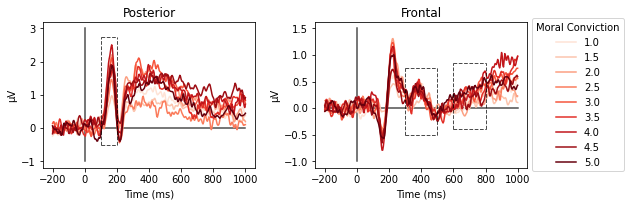

In [22]:
erps = ['epn', 'mfn', 'lpp']
clusters = ['post', 'front']

n_sub = len(sub_labels)
n_mc = 9 # total levels of n_mc
traces = [np.empty((n_sub, n_mc, 301) ),
          np.empty((n_sub, n_mc, 301) )] # one for each cluster

for ii in range(n_sub):
    subject = sub_labels[ii]
    eeg, events, event_dict = import_subeeg(subject, verbose='WARNING')
    existing_issues = [x for x in event_dict.values() if x in issue_vals]
    
    iss_sup = []
    iss_mor = []
    iss_codes = []
    for iss in existing_issues:
        iss_codes.append(iss)
        s, m = parse_issue(iss)
        iss_sup.append(s)
        iss_mor.append(m)

    sub_df_iss = pd.DataFrame({'iss_id': iss_codes, 
                           'support' : iss_sup, 
                           'moral' : iss_mor})

    sub_mcs = sub_df_iss['moral'].unique()
    sub_mcs.sort()
    
    for mi in range(9):
        mc = mi+1
        
        for ci in range(len(clusters)):
            clust = clusters[ci]
            if mc in sub_mcs:
                code_vals = sub_df_iss[sub_df_iss['moral'] == mc]['iss_id'].values

                epoch = mne.Epochs(eeg, events, event_id = code_vals.tolist(), tmin=-0.2, tmax=1,
                               picks = clust_dict[clust], reject=reject_criteria,
                               flat=flat_criteria, reject_by_annotation=False,
                               preload=True, verbose='WARNING')
                edat = epoch.get_data()
                traces[ci][ii,mi,:] = edat.mean(axis=0).mean(axis=0)
                
avg_traces = [np.nanmean(x,axis=0) for x in traces]

n_mc = 9
fig, ax = plt.subplots(1, 2, figsize=(8,8/3))

colors = pl.cm.Reds(  np.linspace(0, 1, n_mc+1))

x = np.linspace(-200, 1000, 301)

for ci in range(2):
    #ax[ii,ci].set_title(f'{labels[ii]} Support')
    if ci == 0:
        ax[ci].plot([0, 0], [-1, 3], '-k', alpha=.7)
    else:
        ax[ci].plot([0, 0], [-1, 1.5], '-k', alpha=.7)
        
    ax[ci].plot([-200, 1000], [0, 0], '-k', alpha=.7)
    for mi in range(n_mc):
        ax[ci].plot(x, avg_traces[ci][mi,:]*1e6, color=colors[mi+1],
                label=f'{(mi+2)/2}')

    box = ax[ci].get_position()
    ax[ci].set_position([box.x0, box.y0, box.width * 0.8, box.height])
    ax[ci].set_xlabel('Time (ms)')
    ax[ci].set_ylabel('μV')
    if ci == 1:
        ax[ci].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Moral Conviction" )
    # add boxes
    if ci == 0:
        add_box(ax[ci], 100, 200, -.5, 2.75) # epn
    if ci == 1:
        add_box(ax[ci], 300, 500, -.5, .75) # mfn
        add_box(ax[ci], 600, 800, -.4, .85) # lpp


pad = 5
cols = ['Posterior', 'Frontal']
for a, col in zip(ax, cols):
    a.annotate(col, xy=(0.5, 1), xytext=(0, pad),
               xycoords='axes fraction', textcoords='offset points',
               size='large', ha='center', va='baseline')
        
fig.tight_layout(h_pad=1.0, w_pad=5.0,pad=0)
fig.savefig('_Rev_Issue_MC_traces_all.png', bbox_inches='tight')

## Plot Social ERPs



Importing subjectPM503


Finding 'sfreq' from header file: export\PM503.vhdr
Used Annotations descriptions: ['Stimulus/-999', 'Stimulus/1125', 'Stimulus/1133', 'Stimulus/1168', 'Stimulus/1219', 'Stimulus/1225', 'Stimulus/1236', 'Stimulus/125', 'Stimulus/1255', 'Stimulus/1317', 'Stimulus/1326', 'Stimulus/133', 'Stimulus/1333', 'Stimulus/134', 'Stimulus/1367', 'Stimulus/1368', 'Stimulus/154', 'Stimulus/167', 'Stimulus/168', 'Stimulus/17', 'Stimulus/179', 'Stimulus/19', 'Stimulus/2', 'Stimulus/21', 'Stimulus/219', 'Stimulus/223', 'Stimulus/2241', 'Stimulus/2243', 'Stimulus/2245', 'Stimulus/225', 'Stimulus/229', 'Stimulus/23', 'Stimulus/234', 'Stimulus/235', 'Stimulus/236', 'Stimulus/241', 'Stimulus/243', 'Stimulus/245', 'Stimulus/25', 'Stimulus/255', 'Stimulus/26', 'Stimulus/29', 'Stimulus/3134', 'Stimulus/3154', 'Stimulus/3167', 'Stimulus/317', 'Stimulus/3179', 'Stimulus/321', 'Stimulus/3223', 'Stimulus/3229', 'Stimulus/3234', 'Stimulus/3235', 'Stimulus/3255', 'Stimulus/326', 'Stimulus

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 163 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)




Importing subjectPM770


Finding 'sfreq' from header file: export\PM770.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1115.0', 'Stimulus/1119.0', 'Stimulus/1123.0', 'Stimulus/113.0', 'Stimulus/1135.0', 'Stimulus/115.0', 'Stimulus/1153.0', 'Stimulus/1175.0', 'Stimulus/1179.0', 'Stimulus/119.0', 'Stimulus/1213.0', 'Stimulus/1223.0', 'Stimulus/123.0', 'Stimulus/1232.0', 'Stimulus/1233.0', 'Stimulus/1235.0', 'Stimulus/125.0', 'Stimulus/1251.0', 'Stimulus/1253.0', 'Stimulus/1254.0', 'Stimulus/1255.0', 'Stimulus/1275.0', 'Stimulus/1277.0', 'Stimulus/1279.0', 'Stimulus/13.0', 'Stimulus/1313.0', 'Stimulus/132.0', 'Stimulus/133.0', 'Stimulus/1335.0', 'Stimulus/135.0', 'Stimulus/1353.0', 'Stimulus/1375.0', 'Stimulus/1377.0', 'Stimulus/15.0', 'Stimulus/153.0', 'Stimulus/154.0', 'Stimulus/155.0', 'Stimulus/175.0', 'Stimulus/177.0', 'Stimulus/179.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/213.0', 'Stimulus/215.0', 'Stimulus/223.0', 'Stimulus/2241.0', 'Stimulus/2242.0', 'St

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 394 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)




Importing subjectPM842


Finding 'sfreq' from header file: export\PM842.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1116.0', 'Stimulus/1118.0', 'Stimulus/1136.0', 'Stimulus/1155.0', 'Stimulus/116.0', 'Stimulus/1176.0', 'Stimulus/118.0', 'Stimulus/119.0', 'Stimulus/1215.0', 'Stimulus/1219.0', 'Stimulus/125.0', 'Stimulus/1255.0', 'Stimulus/1266.0', 'Stimulus/1275.0', 'Stimulus/1318.0', 'Stimulus/1319.0', 'Stimulus/1325.0', 'Stimulus/136.0', 'Stimulus/1365.0', 'Stimulus/1378.0', 'Stimulus/15.0', 'Stimulus/155.0', 'Stimulus/156.0', 'Stimulus/16.0', 'Stimulus/165.0', 'Stimulus/176.0', 'Stimulus/178.0', 'Stimulus/18.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/215.0', 'Stimulus/216.0', 'Stimulus/219.0', 'Stimulus/2245.0', 'Stimulus/2246.0', 'Stimulus/228.0', 'Stimulus/245.0', 'Stimulus/246.0', 'Stimulus/25.0', 'Stimulus/255.0', 'Stimulus/26.0', 'Stimulus/266.0', 'Stimulus/275.0', 'Stimulus/277.0', 'Stimulus/28.0', 'Stimulus/3119.0', 'Stimulus/3125.0', 'Stimulus/3156

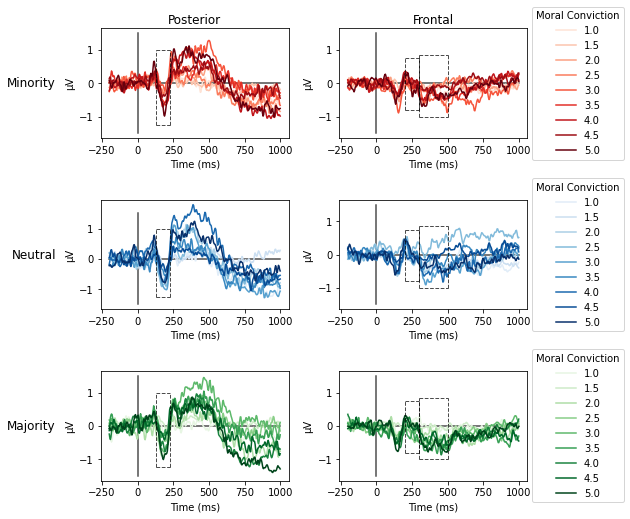

In [23]:
minority_vals = [x + 100 for x in issue_vals]
neutral_vals = [x + 200 for x in issue_vals]
majority_vals = [x + 300 for x in issue_vals]
support_vals = [minority_vals, neutral_vals, majority_vals]

n_sub = len(sub_labels)
n_mc = 9
soc_traces = [ 
          [ np.empty((n_sub, n_mc, 301) ),
            np.empty((n_sub, n_mc, 301) ),
            np.empty((n_sub, n_mc, 301) )],
          [ np.empty((n_sub, n_mc, 301) ),
            np.empty((n_sub, n_mc, 301) ),
            np.empty((n_sub, n_mc, 301) )] ] # one for each cluster / soc support

for ii in range(len(sub_labels)):
    subject = sub_labels[ii]
    print(f'\n\nImporting subject{subject}\n\n')
    eeg, events, event_dict = import_subeeg(subject, verbose='WARNING')
    
    for soc_level in range(3):
        
        existing_soc = [x for x in event_dict.values() if x in support_vals[soc_level] ]
      
        sup = []
        mor = []
        codes = []
        
        for soc in existing_soc:
            codes.append(soc)
            _, s, m = parse_soc(soc)
            sup.append(s)
            mor.append(m)
        
        sub_df = pd.DataFrame({'id' : codes,
                               'support' : sup,
                               'moral' : mor})
        
        sub_mcs = sub_df['moral'].unique()
        sub_mcs.sort()
        
        for mi in range(9):
            mc = mi+1
            
            for ci in range(len(clusters)):
                clust = clusters[ci]
                if mc in sub_mcs:
                    code_vals = sub_df[sub_df['moral'] == mc]['id'].values

                    epoch = mne.Epochs(eeg, events, event_id = code_vals.tolist(),
                                       tmin=-0.2, tmax=1, picks=clust_dict[clust],
                                       reject=reject_criteria, flat=flat_criteria,
                                       reject_by_annotation=False, preload=True,
                                       verbose='WARNING')
                    edat = epoch.get_data()

                    soc_traces[ci][soc_level][ii,mi,:] = edat.mean(axis=0).mean(axis=0)

min_traces = [soc_traces[0][0], soc_traces[1][0]]
neu_traces = [soc_traces[0][1], soc_traces[1][1]]
maj_traces = [soc_traces[0][2], soc_traces[1][2]]

avg_min = [np.nanmean(x, axis=0) for x in min_traces]
avg_neu = [np.nanmean(x, axis=0) for x in neu_traces]
avg_maj = [np.nanmean(x, axis=0) for x in maj_traces]

avg_soc = [avg_min, avg_neu, avg_maj]


fig, ax = plt.subplots(3, 2, figsize=(8,7))

colors = [pl.cm.Reds(  np.linspace(0, 1, n_mc+1)),
          pl.cm.Blues( np.linspace(0, 1, n_mc+1)),
          pl.cm.Greens(np.linspace(0, 1, n_mc+1))]

labels = ['Minority', 'Neutral', 'Majority']

x = np.linspace(-200, 1000, 301)

for ii in range(3):
    for ci in range(2):
        #ax[ii,ci].set_title(f'{labels[ii]} Support')
        ax[ii,ci].plot([0, 0], [-1.5, 1.5], '-k', alpha=.7)
        ax[ii,ci].plot([-200, 1000], [0, 0], '-k', alpha=.7)
        for mi in range(n_mc):
            ax[ii,ci].plot(x, avg_soc[ii][ci][mi,:]*1e6, color=colors[ii][mi+1],
                    label=f'{(mi+2)/2}')

        box = ax[ii,ci].get_position()
        ax[ii,ci].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax[ii,ci].set_xlabel('Time (ms)')
        ax[ii,ci].set_ylabel('μV')
        if ci == 1:
            ax[ii,ci].legend(loc='center left', bbox_to_anchor=(1, 0.5), title="Moral Conviction" )
            
        # add boxes
        if ci == 0:
            add_box(ax[ii,ci], 125, 225, -1.25, 1) # epn
        if ci == 1:
            add_box(ax[ii,ci], 200, 300, -.8, .75) # mfn
            add_box(ax[ii,ci], 300, 500, -1, .85) # lpp

pad = 5
rows = ['Minority', 'Neutral', 'Majority']
cols = ['Posterior', 'Frontal']
for a, row in zip(ax[:,0], rows):
    a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
               xycoords=a.yaxis.label, textcoords='offset points',
               size='large', ha='right', va='center')
for a, col in zip(ax[0], cols):
    a.annotate(col, xy=(0.5, 1), xytext=(0, pad),
               xycoords='axes fraction', textcoords='offset points',
               size='large', ha='center', va='baseline')
        
fig.tight_layout(h_pad=1.0, w_pad=5.0,pad=0)
fig.savefig('Social_MC_traces_all.png', bbox_inches='tight')

## Plot Photo ERPS

Finding 'sfreq' from header file: export\PM503.vhdr
Used Annotations descriptions: ['Stimulus/-999', 'Stimulus/1125', 'Stimulus/1133', 'Stimulus/1168', 'Stimulus/1219', 'Stimulus/1225', 'Stimulus/1236', 'Stimulus/125', 'Stimulus/1255', 'Stimulus/1317', 'Stimulus/1326', 'Stimulus/133', 'Stimulus/1333', 'Stimulus/134', 'Stimulus/1367', 'Stimulus/1368', 'Stimulus/154', 'Stimulus/167', 'Stimulus/168', 'Stimulus/17', 'Stimulus/179', 'Stimulus/19', 'Stimulus/2', 'Stimulus/21', 'Stimulus/219', 'Stimulus/223', 'Stimulus/2241', 'Stimulus/2243', 'Stimulus/2245', 'Stimulus/225', 'Stimulus/229', 'Stimulus/23', 'Stimulus/234', 'Stimulus/235', 'Stimulus/236', 'Stimulus/241', 'Stimulus/243', 'Stimulus/245', 'Stimulus/25', 'Stimulus/255', 'Stimulus/26', 'Stimulus/29', 'Stimulus/3134', 'Stimulus/3154', 'Stimulus/3167', 'Stimulus/317', 'Stimulus/3179', 'Stimulus/321', 'Stimulus/3223', 'Stimulus/3229', 'Stimulus/3234', 'Stimulus/3235', 'Stimulus/3255', 'Stimulus/326', 'Stimulus/33', 'Stimulus/3321', 'Sti

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 163 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)


Finding 'sfreq' from header file: export\PM770.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1115.0', 'Stimulus/1119.0', 'Stimulus/1123.0', 'Stimulus/113.0', 'Stimulus/1135.0', 'Stimulus/115.0', 'Stimulus/1153.0', 'Stimulus/1175.0', 'Stimulus/1179.0', 'Stimulus/119.0', 'Stimulus/1213.0', 'Stimulus/1223.0', 'Stimulus/123.0', 'Stimulus/1232.0', 'Stimulus/1233.0', 'Stimulus/1235.0', 'Stimulus/125.0', 'Stimulus/1251.0', 'Stimulus/1253.0', 'Stimulus/1254.0', 'Stimulus/1255.0', 'Stimulus/1275.0', 'Stimulus/1277.0', 'Stimulus/1279.0', 'Stimulus/13.0', 'Stimulus/1313.0', 'Stimulus/132.0', 'Stimulus/133.0', 'Stimulus/1335.0', 'Stimulus/135.0', 'Stimulus/1353.0', 'Stimulus/1375.0', 'Stimulus/1377.0', 'Stimulus/15.0', 'Stimulus/153.0', 'Stimulus/154.0', 'Stimulus/155.0', 'Stimulus/175.0', 'Stimulus/177.0', 'Stimulus/179.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/213.0', 'Stimulus/215.0', 'Stimulus/223.0', 'Stimulus/2241.0', 'Stimulus/2242.0', 'Stimulus/2243.0', 'Stimulus/2

C:\Users\KEITHY~1\AppData\Local\Temp/ipykernel_38180/364004904.py:17: RuntimeWarning: Omitted 394 annotation(s) that were outside data range.
  raw = mne.io.read_raw_edf(base_dir / f'{subject}_Protest.edf', **kwargs)


Finding 'sfreq' from header file: export\PM842.vhdr
Used Annotations descriptions: ['Stimulus/-999.0', 'Stimulus/1116.0', 'Stimulus/1118.0', 'Stimulus/1136.0', 'Stimulus/1155.0', 'Stimulus/116.0', 'Stimulus/1176.0', 'Stimulus/118.0', 'Stimulus/119.0', 'Stimulus/1215.0', 'Stimulus/1219.0', 'Stimulus/125.0', 'Stimulus/1255.0', 'Stimulus/1266.0', 'Stimulus/1275.0', 'Stimulus/1318.0', 'Stimulus/1319.0', 'Stimulus/1325.0', 'Stimulus/136.0', 'Stimulus/1365.0', 'Stimulus/1378.0', 'Stimulus/15.0', 'Stimulus/155.0', 'Stimulus/156.0', 'Stimulus/16.0', 'Stimulus/165.0', 'Stimulus/176.0', 'Stimulus/178.0', 'Stimulus/18.0', 'Stimulus/19.0', 'Stimulus/2.0', 'Stimulus/215.0', 'Stimulus/216.0', 'Stimulus/219.0', 'Stimulus/2245.0', 'Stimulus/2246.0', 'Stimulus/228.0', 'Stimulus/245.0', 'Stimulus/246.0', 'Stimulus/25.0', 'Stimulus/255.0', 'Stimulus/26.0', 'Stimulus/266.0', 'Stimulus/275.0', 'Stimulus/277.0', 'Stimulus/28.0', 'Stimulus/3119.0', 'Stimulus/3125.0', 'Stimulus/3156.0', 'Stimulus/3165.0', 'St

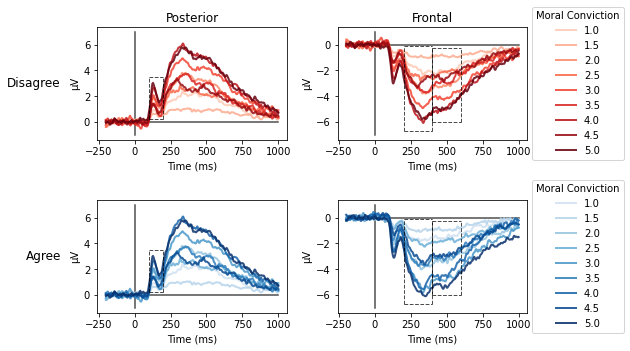

In [24]:
disagree_vals = [x + 1000 for x in soc_vals]
unclear_vals = [x + 2000 for x in soc_vals]
agree_vals = [x + 3000 for x in soc_vals]
pic_vals = [disagree_vals, agree_vals]

n_sub = len(sub_labels)
n_mc = 9
traces = [ [np.empty((n_sub, n_mc, 301) ),
            np.empty((n_sub, n_mc, 301) )],
           [np.empty((n_sub, n_mc, 301) ),
            np.empty((n_sub, n_mc, 301) )] ]# one for each cluster and agree|disagree

for ii in range(len(sub_labels)):
    subject = sub_labels[ii]
    eeg, events, event_dict = import_subeeg(subject, verbose='WARNING')
    
    for pic_level in range(2):
        
        existing_pic = [x for x in event_dict.values() if x in pic_vals[pic_level] ]
      
        sup = []
        mor = []
        codes = []
        
        for pic in existing_pic:
            codes.append(pic)
            _, _, s, m = parse_pic(pic)
            sup.append(s)
            mor.append(m)
        
        sub_df = pd.DataFrame({'id' : codes,
                               'support' : sup,
                               'moral' : mor})
        
        sub_mcs = sub_df['moral'].unique()
        sub_mcs.sort()
        
        for mi in range(9):
            mc = mi+1
            
            for ci in range(2):
                clust = clusters[ci]
                if mc in sub_mcs:
                    clust = 'post'
                    code_vals = sub_df[sub_df['moral'] == mc]['id'].values

                    epoch = mne.Epochs(eeg, events, event_id = code_vals.tolist(),
                                       tmin=-0.2, tmax=1, picks=clust_dict[clust],
                                       reject=reject_criteria, flat=flat_criteria,
                                       reject_by_annotation=False, preload=True,
                                       verbose='WARNING')
                    edat = epoch.get_data()

                    traces[ci][pic_level][ii,mi,:] = edat.mean(axis=0).mean(axis=0)

# collect traces by condition
disagree_traces = [ traces[0][0], traces[1][0] ]
agree_traces    = [ traces[1][0], traces[1][1] ]

avg_disagree = [np.nanmean(x, axis=0) for x in disagree_traces]
avg_agree    = [np.nanmean(x, axis=0) for x in agree_traces]

avg_traces = [avg_disagree, avg_agree]


n_bin=9

fig, ax = plt.subplots(2,2, figsize=(8,(7/3)*2))

colors = [pl.cm.Reds(  np.linspace(0, 1, n_bin+2)),
          pl.cm.Blues( np.linspace(0, 1, n_bin+2))]

labels = ['Disagree', 'Agree']

x = np.linspace(-200, 1000, 301)

for ii in range(len(labels)):
    for ci in range(2):
        
        ax[ii,ci].plot([-200, 1000], [0, 0], '-k', alpha=.7)
        if ci==0:
            ax[ii,ci].plot([0, 0], [-1, 7], '-k', alpha=.7)
            for mi in range(n_mc):
                ax[ii,ci].plot(x, avg_traces[ii][ci][mi,:]*1e6, 
                               color=colors[ii][mi+2], label=f'{(mi+2)/2}', 
                               alpha=.85, linewidth=2)
        else:
            ax[ii,ci].plot([0, 0], [1, -7], '-k', alpha=.7)
            for mi in range(n_mc):
                ax[ii,ci].plot(x, avg_traces[ii][ci][mi,:]*-1e6, 
                               color=colors[ii][mi+2], label=f'{(mi+2)/2}', 
                               alpha=.85, linewidth=2)
            


        box = ax[ii,ci].get_position()
        ax[ii,ci].set_position([box.x0, box.y0, box.width * 0.8, box.height])
        ax[ii,ci].set_xlabel('Time (ms)')
        ax[ii,ci].set_ylabel('μV')
        #ax[ii,ci].set_title(labels[ii])
        if ci == 1:
            ax[ii,ci].legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Moral Conviction' )
            
        # add boxes
        if ci == 0:
            add_box(ax[ii,ci], 100, 200, .25, 3.5) # epn
        if ci == 1:
            add_box(ax[ii,ci], 200, 400, -6.75, -.1) # mfn
            add_box(ax[ii,ci], 400, 600, -6, -.25) # lpp
            
pad = 5
rows = ['Disagree', 'Agree']
cols = ['Posterior', 'Frontal']
for a, row in zip(ax[:,0], rows):
    a.annotate(row, xy=(0, 0.5), xytext=(-a.yaxis.labelpad - pad, 0),
               xycoords=a.yaxis.label, textcoords='offset points',
               size='large', ha='right', va='center')
for a, col in zip(ax[0], cols):
    a.annotate(col, xy=(0.5, 1), xytext=(0, pad),
               xycoords='axes fraction', textcoords='offset points',
               size='large', ha='center', va='baseline')
    
fig.tight_layout(h_pad=1.0, w_pad=5.0,pad=0)

fig.savefig('Photo_MC_traces_post.png', bbox_inches='tight')